# SUOX: Sulfite Oxidase Deficiency

[Sulfite oxidase deficiency (ISOD)](https://omim.org/entry/272300) is caused by homozygous or compound heterozygous mutation in the sulfite oxidase gene (SUOX).

Data from [Li JT, et al. Mutation analysis of SUOX in isolated sulfite oxidase deficiency with ectopia lentis as the presenting feature: insights into genotype-phenotype correlation](https://pubmed.ncbi.nlm.nih.gov/36303223/)

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### SUOX
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SUOX.

In [2]:
gene_symbol = 'NKX6-2'
mane_tx_id = 'NM_001032386.2' 
mane_protein_id = 'NP_001027558.1' # sulfite oxidase, mitochondrial

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.22") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder
cohort_creator = configure_caching_cohort_creator(hpo)

"""
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
"""
ppkt = "../../../phenopacket-store/notebooks/SUOX/phenopackets"
cohort, validation = load_phenopacket_folder(  
    #phenopackets=phenopackets,
    pp_directory=ppkt,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 33 phenopackets
Individuals Processed: 35individuals [00:00, 486.03individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Seizure,HP:0001250,28
Sulfocysteinuria,HP:0032350,18
Hypotonia,HP:0001252,15
Hypertonia,HP:0001276,11
Abnormality of extrapyramidal motor function,HP:0002071,11
Microcephaly,HP:0000252,10
Hypohomocysteinemia,HP:0020222,10
Hypocystinemia,HP:0500152,9
Global developmental delay,HP:0001263,8
Hypouricemia,HP:0003537,7


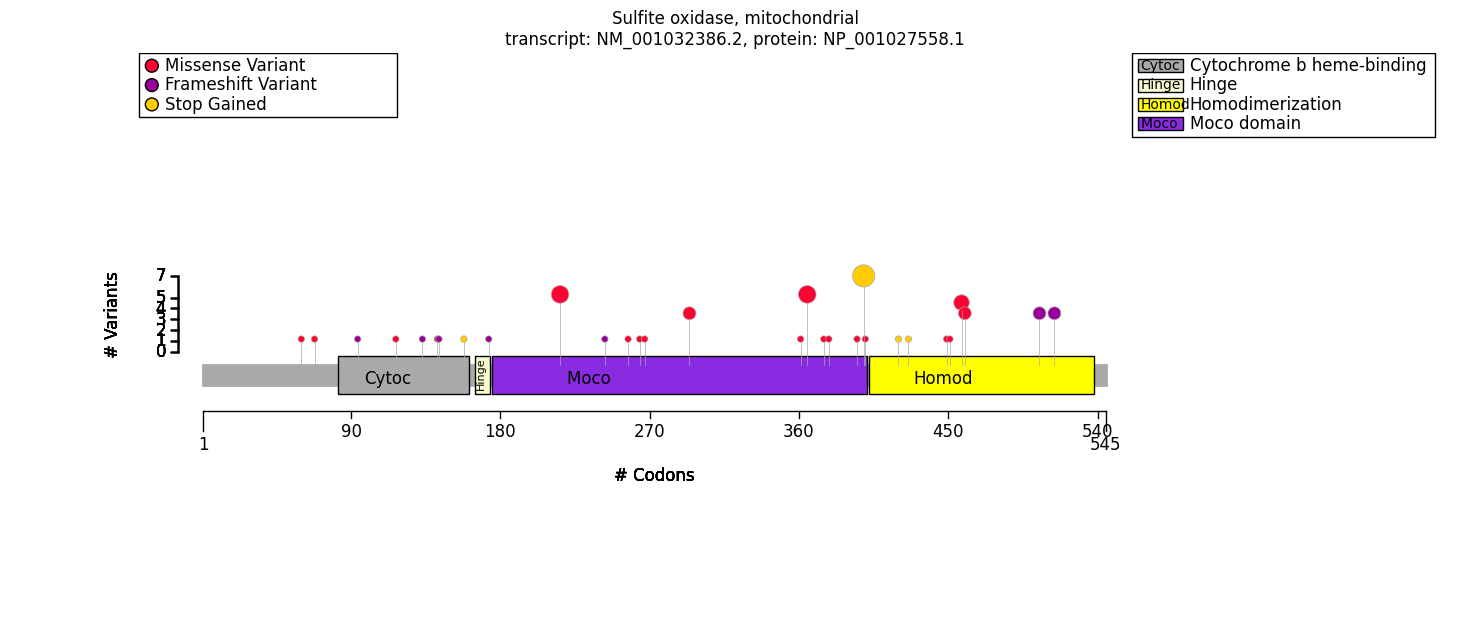

In [ ]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

suox_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
suox_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
html_prot = viewer.process(cohort)
html_prot

Name,Type,Coordinates,Count,Variants
Cytochrome b5 heme-binding,DOMAIN,82 - 161,6,p.Glu159Ter; p.His118Tyr; p.His143Asn; p.Glu97Ter; p.Gln145SerfsTer16; p.Glu134ProfsTer26
Hinge,REGION,165 - 174,1,p.Asp174ThrfsTer13
Moco domain,REGION,175 - 401,26,p.Gly295Glu; p.Lys401Glu; p.Arg366His; p.Arg217Gly; p.Ala265Asp; p.Arg217Gln; p.Arg366Cys; p.Leu245ProfsTer27; p.Gly362Ser; p.Arg268Gln; p.Gln396Arg; p.Tyr400Ter; p.Ile258Leu; p.Lys379Arg; p.Arg376Cys
Homodimerization,REGION,402 - 538,13,p.Cys508ArgfsTer109; p.Asp461Val; p.Gln421Ter; p.Ile525MetfsTer102; p.Ser427Ter; p.Arg459Gln; p.Gly452Asp; p.Trp450Arg


In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
12_56004589_56004589_C_G,c.1200C>G,p.Tyr400Ter,5,stop gained,7
12_56004485_56004485_C_T,c.1096C>T,p.Arg366Cys,5,missense,3
12_56004765_56004765_G_A,c.1376G>A,p.Arg459Gln,5,missense,3
12_56004039_56004039_G_A,c.650G>A,p.Arg217Gln,5,missense,3
12_56004933_56004933_A_ACAATGTGCAGCCAGACACCGTGGCCC,c.1549_1574dup,p.Ile525MetfsTer102,5,frameshift,2
12_56004905_56004909_ATTGT_A,c.1521_1524del,p.Cys508ArgfsTer109,5,frameshift,2
12_56004273_56004273_G_A,c.884G>A,p.Gly295Glu,5,missense,2
12_56004771_56004771_A_T,c.1382A>T,p.Asp461Val,5,missense,2
12_56004038_56004038_C_G,c.649C>G,p.Arg217Gly,5,missense,1
12_56003864_56003864_G_T,c.475G>T,p.Glu159Ter,5,stop gained,1


# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = biallelic_predicate(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other",
    partitions=((0,1), (2,))
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)


viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,2
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,26
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,30


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense/Missense OR Missense/Other  \
                                                                                 Count   
Seizure [HP:0001250]                                                             17/24   
Hypouricemia [HP:0003537]                                                         3/11   
Hypotonia [HP:0001252]                                                           12/16   
Abnormality of extrapyramidal motor function [H...                                9/17   
Global developmental delay [HP:0001263]                                           4/17   
Microcephaly [HP:0000252]                                                         6/14   
Hypertonia [HP:0001276]                                                           7/16   
Abnormal muscle tone [HP:0003808]                                                14/14   
Neurodevelopmental abnormality [HP:0012759]                                      10/10   
Sulfocysteinuria [HP:0032350]                                                    13/13   
Aminoaciduria [HP:0003355]                                                       13/13   
Abnormal circulating sulfur amino acid concentr...                               10/10   
Abnormal circulating amino acid concentration [...                               10/10   
Ectopia lentis [HP:0001083]                                                       6/15   

Allele group                                               Other/Other  \
                                                   Percent       Count   
Seizure [HP:0001250]                                   71%       11/11   
Hypouricemia [HP:0003537]                              27%         4/5   
Hypotonia [HP:0001252]                                 75%         3/7   
Abnormality of extrapyramidal motor function [H...     53%         2/8   
Global developmental delay [HP:0001263]                24%         4/8   
Microcephaly [HP:0000252]                              43%         4/7   
Hypertonia [HP:0001276]                                44%         4/7   
Abnormal muscle tone [HP:0003808]                     100%         5/5   
Neurodevelopmental abnormality [HP:0012759]           100%         4/4   
Sulfocysteinuria [HP:0032350]                         100%         5/5   
Aminoaciduria [HP:0003355]                            100%         5/5   
Abnormal circulating sulfur amino acid concentr...    100%         5/5   
Abnormal circulating amino acid concentration [...    100%         5/5   
Ectopia lentis [HP:0001083]                            40%         1/3   

Allele group                                                                   \
                                                   Percent Corrected p values   
Seizure [HP:0001250]                                  100%           0.740385   
Hypouricemia [HP:0003537]                              80%           0.740385   
Hypotonia [HP:0001252]                                 43%           0.817895   
Abnormality of extrapyramidal motor function [H...     25%           0.817895   
Global developmental delay [HP:0001263]                50%           1.000000   
Microcephaly [HP:0000252]                              57%           1.000000   
Hypertonia [HP:0001276]                                57%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Sulfocysteinuria [HP:0032350]                         100%           1.000000   
Aminoaciduria [HP:0003355]                            100%           1.000000   
Abnormal circulating sulfur amino acid concentr...    100%           1.000000   
Abnormal circulating amino acid concentration [...    100%           1.000000   
Ectopia lentis [HP:0001083]                            33%           1.000000   

Allele group                                                  
              

In [11]:
moco = VariantPredicates.protein_feature(feature_id="Moco domain", protein_metadata=protein_meta)
moco_predicate = biallelic_predicate(
    a_predicate=moco,
    b_predicate=~moco,
    a_label="Missense",
    b_label="Other",
    partitions=((0,1), (2,))
)

moco_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=moco_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=moco_result)

Allele group                                       Missense/Missense OR Missense/Other  \
                                                                                 Count   
Global developmental delay [HP:0001263]                                           3/16   
Seizure [HP:0001250]                                                             21/24   
Hypouricemia [HP:0003537]                                                         4/12   
Hypotonia [HP:0001252]                                                            8/14   
Hypertonia [HP:0001276]                                                           8/14   
Microcephaly [HP:0000252]                                                         7/13   
Abnormality of extrapyramidal motor function [H...                                8/16   
Abnormal muscle tone [HP:0003808]                                                11/11   
Neurodevelopmental abnormality [HP:0012759]                                        7/7   
Sulfocysteinuria [HP:0032350]                                                      9/9   
Aminoaciduria [HP:0003355]                                                         9/9   
Abnormal circulating sulfur amino acid concentr...                                 8/8   
Abnormal circulating amino acid concentration [...                                 8/8   
Ectopia lentis [HP:0001083]                                                       5/12   

Allele group                                               Other/Other  \
                                                   Percent       Count   
Global developmental delay [HP:0001263]                19%         5/9   
Seizure [HP:0001250]                                   88%        7/11   
Hypouricemia [HP:0003537]                              33%         3/4   
Hypotonia [HP:0001252]                                 57%         7/9   
Hypertonia [HP:0001276]                                57%         3/9   
Microcephaly [HP:0000252]                              54%         3/8   
Abnormality of extrapyramidal motor function [H...     50%         3/9   
Abnormal muscle tone [HP:0003808]                     100%         8/8   
Neurodevelopmental abnormality [HP:0012759]           100%         7/7   
Sulfocysteinuria [HP:0032350]                         100%         9/9   
Aminoaciduria [HP:0003355]                            100%         9/9   
Abnormal circulating sulfur amino acid concentr...    100%         7/7   
Abnormal circulating amino acid concentration [...    100%         7/7   
Ectopia lentis [HP:0001083]                            42%         2/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Global developmental delay [HP:0001263]                56%                1.0   
Seizure [HP:0001250]                                   64%                1.0   
Hypouricemia [HP:0003537]                              75%                1.0   
Hypotonia [HP:0001252]                                 78%                1.0   
Hypertonia [HP:0001276]                                33%                1.0   
Microcephaly [HP:0000252]                              38%                1.0   
Abnormality of extrapyramidal motor function [H...     33%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Sulfocysteinuria [HP:0032350]                         100%                1.0   
Aminoaciduria [HP:0003355]                            100%                1.0   
Abnormal circulating sulfur amino acid concentr...    100%                1.0   
Abnormal circulating amino acid concentration [...    100%                1.0   
Ectopia lentis [HP:0001083]                            33%                1.0   

Allele group                                                  
              

In [12]:
homodimerization = VariantPredicates.protein_feature(feature_id="Homodimerization", protein_metadata=protein_meta)
homodimerization_predicate = biallelic_predicate(
    a_predicate=homodimerization,
    b_predicate=~homodimerization,
    a_label="homodimerization",
    b_label="Other",
    partitions=((0,1), (2,))
)

homodimerization_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=homodimerization_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=homodimerization_result)

Allele group                                       homodimerization/homodimerization OR homodimerization/Other  \
                                                                                                         Count   
Microcephaly [HP:0000252]                                                                         0/9            
Developmental regression [HP:0002376]                                                            5/11            
Hypertonia [HP:0001276]                                                                          3/10            
Global developmental delay [HP:0001263]                                                          2/11            
Ectopia lentis [HP:0001083]                                                                       1/6            
Seizure [HP:0001250]                                                                             9/13            
Abnormality of extrapyramidal motor function [H...                                               6/11            
Hypouricemia [HP:0003537]                                                                         3/9            
Hypotonia [HP:0001252]                                                                           6/10            
Abnormal muscle tone [HP:0003808]                                                                 8/8            
Neurodevelopmental abnormality [HP:0012759]                                                       7/7            
Sulfocysteinuria [HP:0032350]                                                                     5/5            
Aminoaciduria [HP:0003355]                                                                        5/5            
Abnormal circulating sulfur amino acid concentr...                                                8/8            
Abnormal circulating amino acid concentration [...                                                8/8            

Allele group                                               Other/Other  \
                                                   Percent       Count   
Microcephaly [HP:0000252]                               0%       10/12   
Developmental regression [HP:0002376]                  45%        1/14   
Hypertonia [HP:0001276]                                30%        8/13   
Global developmental delay [HP:0001263]                18%        6/14   
Ectopia lentis [HP:0001083]                            17%        6/12   
Seizure [HP:0001250]                                   69%       19/22   
Abnormality of extrapyramidal motor function [H...     55%        5/14   
Hypouricemia [HP:0003537]                              33%         4/7   
Hypotonia [HP:0001252]                                 60%        9/13   
Abnormal muscle tone [HP:0003808]                     100%       11/11   
Neurodevelopmental abnormality [HP:0012759]           100%         7/7   
Sulfocysteinuria [HP:0032350]                         100%       13/13   
Aminoaciduria [HP:0003355]                            100%       13/13   
Abnormal circulating sulfur amino acid concentr...    100%         7/7   
Abnormal circulating amino acid concentration [...    100%         7/7   

Allele group                                                                   \
                                                   Percent Corrected p values   
Microcephaly [HP:0000252]                              83%           0.003317   
Developmental regression [HP:0002376]                   7%           0.420652   
Hypertonia [HP:0001276]                                62%           0.876316   
Global developmental delay [HP:0001263]                43%           0.876316   
Ectopia lentis [HP:0001083]                            50%           0.931415   
Seizure [HP:0001250]                                   86%           0.931415   
Abnormality of extrapyramidal motor function [H...     36%           0.931415   
Hypouricemia [HP:0003537]                              57%           1.00

In [13]:
from gpsea.analysis.temporal.endpoint import disease_onset
suox = "OMIM:272300" # Sulfite oxidase deficiency	


endpoint = disease_onset(disease_id=suox)
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=missense_predicate,
    endpoint=endpoint,
)
print(f"survival analysis p={missense_onset_result.pval:.5f}")

survival analysis p=0.00001


Text(1000, 0.6, '$p=0.00001$')

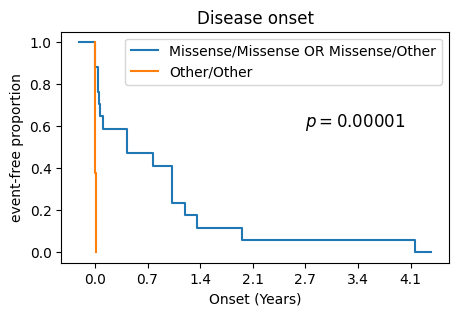

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

missense_onset_fig, ax = plt.subplots(figsize=(5, 3))
missense_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
s = f"p={missense_onset_result.pval:.5f}"
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12)

In [15]:
homodimerization_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=homodimerization_predicate,
    endpoint=endpoint,
)
print(f"survival analysis p={missense_onset_result.pval:.5e}")

survival analysis p=9.17635e-06


Text(1000, 0.6, '$p=0.85327$')

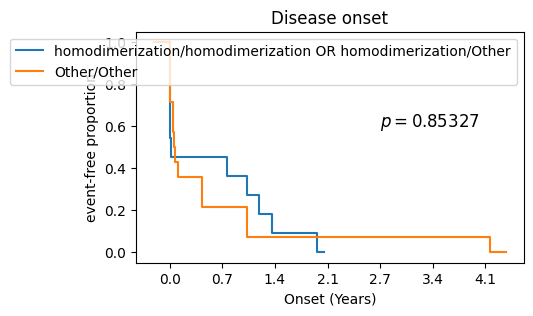

In [ ]:
hd_onset_fig, ax = plt.subplots(figsize=(5, 3))
homodimerization_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
s = f"p={homodimerization_onset_result.pval:.5f}"
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12)

# Summary

In [17]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport


m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=homodimerization_onset_result
    ),
    
)

f_results =  (
    GPAnalysisResultSummary.from_multi(
        result=homodimerization_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=moco_result,
    ), 
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [18]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [ ]:
# summarizer.process_latex(report=report, protein_fig=suox_fig, stats_fig=missense_onset_fig)